In [1]:
using ITensors

In [2]:
using Plots

In [3]:
using SparseArrays, LinearAlgebra, Arpack, LsqFit

# 1. J1-J2 spin 1/2 chain

##     1. Heisenberg Hamiltonian construction for finite J2 term

Using

$\vec{S_{i}\cdot}\vec{S}_{j}=S_{i}^{z}S_{j}^{z}+\frac{1}{2}(S_{i}^{+}S_{j}^{-}+S_{i}^{-}S_{j}^{+})$

The hamiltonian gets the form

$ H=J_{1}\sum_{i}\vec{S_{i}\cdot}\vec{S}_{i+1}+J_{2}\sum_{i}\vec{S_{i}}\cdot\vec{S_{i+2}}$

$    =J_{1}\sum_{i}\left(S_{i}^{z}S_{i+1}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+1}^{-}+S_{i}^{-}S_{i+1}^{+})\right)+J_{2}\sum_{i}\left(S_{i}^{z}S_{i+2}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+2}^{-}+S_{i}^{-}S_{i+2}^{+})\right) $

Generalization of the method seen in class 6 for the MPO will lead to the matrices


$W_{(L)}=\left(\begin{array}{c}
I\\
S^{z}\\
S^{+}\\
S^{-}\\
0\\
0\\
0\\
0
\end{array}\right)$

$W_{(i)}=\left(\begin{array}{cccccccc}
I & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{z} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{+} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{-} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & I & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & I & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & I & 0 & 0 & 0 & 0\\
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I
\end{array}\right)$

$W_{(1)}=\left(\begin{array}{cccccccc}
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I\end{array}\right)$

In [11]:
function J1J2_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64, QN_subspace::Int64; zeros_init::Bool = false)
    
    sites = siteinds("S=1/2", N; conserve_qns=true)

    ampo = OpSum()

    for j = 1:N
        if j < N
            ampo += J1, "Sz", j, "Sz", j + 1
            ampo += J1/2, "S+", j, "S-", j + 1 
            ampo += J1/2, "S-", j, "S+", j + 1
        end
        if j < N-1
            ampo += J2, "Sz", j, "Sz", j + 2
            ampo += J2/2, "S+", j, "S-", j + 2 
            ampo += J2/2, "S-", j, "S+", j + 2
        end 
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    #psi0 = randomMPS(sites,10)
    state= [isodd(n) ? "Up" : "Dn" for n=1:N]
    if QN_subspace == 1
        state[2]="Up"
    end
    psi0 = MPS(sites,state)
    
    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps);

    return energy, psi
end;

## 2. Finite size scaling

In [5]:
function energy_gap_calc(H_func,N_arr,g,swp_num,maxM,base_subspace=0,excited_subspace=1 ; return_states = false, zeros_init = false)
    delta_arr=[]
    psi_0_arr=[]
    psi_excited_arr=[]
    J1=1.
    J2=g*J1
    for N in N_arr
        energy_s0, psi_0 = H_func(N, J1, J2, swp_num, maxM ,base_subspace ;zeros_init=zeros_init);
        energy_s_excited, psi_excited = H_func(N, J1, J2, swp_num, maxM,excited_subspace;zeros_init=zeros_init);
        push!(delta_arr, energy_s_excited-energy_s0)
        push!(psi_0_arr,psi_0)
        push!(psi_excited_arr,psi_excited)
    end
    if !return_states
        return delta_arr
    else
        return delta_arr, psi_0_arr, psi_excited_arr
    end
end;

In [6]:
N_arr= [ n for n in 20:20:100];
swp_num = 10
maxM = 100
g_arr=[0 ,0.241, 0.48];

In [12]:
j1j2spin_half_deltas_arr=[]
for g in g_arr
    push!(j1j2spin_half_deltas_arr,energy_gap_calc(J1J2_DMRG,N_arr,g,swp_num,maxM))
end;

After sweep 1 energy=-8.60514183065435  maxlinkdim=4 maxerr=0.00E+00 time=33.982
After sweep 2 energy=-8.681922609869904  maxlinkdim=16 maxerr=0.00E+00 time=1.368
After sweep 3 energy=-8.682473323653621  maxlinkdim=64 maxerr=8.77E-17 time=0.665
After sweep 4 energy=-8.68247333439891  maxlinkdim=99 maxerr=9.81E-17 time=0.244
After sweep 5 energy=-8.682473334398972  maxlinkdim=97 maxerr=1.04E-16 time=0.296
After sweep 6 energy=-8.682473334398976  maxlinkdim=97 maxerr=8.94E-17 time=0.276
After sweep 7 energy=-8.682473334398955  maxlinkdim=97 maxerr=8.94E-17 time=0.310
After sweep 8 energy=-8.682473334398965  maxlinkdim=97 maxerr=8.94E-17 time=0.287
After sweep 9 energy=-8.682473334398964  maxlinkdim=97 maxerr=8.94E-17 time=0.265
After sweep 10 energy=-8.68247333439896  maxlinkdim=97 maxerr=8.94E-17 time=0.319
After sweep 1 energy=-7.910060820117726  maxlinkdim=4 maxerr=0.00E+00 time=0.055
After sweep 2 energy=-8.479555924186457  maxlinkdim=16 maxerr=0.00E+00 time=0.096
After sweep 3 energ

After sweep 10 energy=-44.08729916754671  maxlinkdim=100 maxerr=1.76E-10 time=2.369
After sweep 1 energy=-7.893031868110662  maxlinkdim=4 maxerr=0.00E+00 time=0.141
After sweep 2 energy=-7.94944575912862  maxlinkdim=16 maxerr=0.00E+00 time=0.171
After sweep 3 energy=-7.94978613502113  maxlinkdim=64 maxerr=9.98E-17 time=0.218
After sweep 4 energy=-7.949786241657115  maxlinkdim=100 maxerr=6.60E-16 time=0.351
After sweep 5 energy=-7.949786241662649  maxlinkdim=100 maxerr=2.41E-16 time=0.456
After sweep 6 energy=-7.949786241662642  maxlinkdim=100 maxerr=1.70E-16 time=0.408
After sweep 7 energy=-7.949786241662626  maxlinkdim=100 maxerr=1.70E-16 time=0.390
After sweep 8 energy=-7.949786241662648  maxlinkdim=100 maxerr=1.70E-16 time=0.424
After sweep 9 energy=-7.949786241662641  maxlinkdim=100 maxerr=1.70E-16 time=0.426
After sweep 10 energy=-7.949786241662631  maxlinkdim=100 maxerr=1.70E-16 time=0.384
After sweep 1 energy=-7.267425336676245  maxlinkdim=4 maxerr=0.00E+00 time=0.068
After swee

After sweep 9 energy=-40.06545406548293  maxlinkdim=100 maxerr=8.84E-11 time=5.277
After sweep 10 energy=-40.06553217396506  maxlinkdim=100 maxerr=5.58E-11 time=5.236
After sweep 1 energy=-7.49616712208073  maxlinkdim=4 maxerr=0.00E+00 time=0.059
After sweep 2 energy=-7.503861902049232  maxlinkdim=16 maxerr=0.00E+00 time=0.139
After sweep 3 energy=-7.503869774420087  maxlinkdim=64 maxerr=7.84E-17 time=0.245
After sweep 4 energy=-7.503869788818607  maxlinkdim=100 maxerr=3.64E-16 time=0.416
After sweep 5 energy=-7.503869788823641  maxlinkdim=91 maxerr=2.01E-16 time=0.476
After sweep 6 energy=-7.503869788823639  maxlinkdim=86 maxerr=9.98E-17 time=0.391
After sweep 7 energy=-7.503869788823646  maxlinkdim=86 maxerr=9.94E-17 time=0.453
After sweep 8 energy=-7.503869788823656  maxlinkdim=86 maxerr=9.94E-17 time=0.449
After sweep 9 energy=-7.503869788823648  maxlinkdim=86 maxerr=9.94E-17 time=0.348
After sweep 10 energy=-7.503869788823638  maxlinkdim=86 maxerr=9.94E-17 time=0.379
After sweep 1

After sweep 8 energy=-37.30391943337031  maxlinkdim=100 maxerr=4.45E-11 time=4.779
After sweep 9 energy=-37.30837316989935  maxlinkdim=100 maxerr=6.28E-11 time=5.117
After sweep 10 energy=-37.31212928522433  maxlinkdim=100 maxerr=8.88E-11 time=5.364


In [13]:
function plot_delta_energies(deltas,N_array,g; plot_fit=true)
    x = 1 ./ N_array
    fun(x, a) = a[1] .+ a[2]*x
    res = LsqFit.curve_fit(fun, x, deltas, [0., 0.]);
    plt=scatter(x, deltas,linestyle = :dot,title="Energy deltas g=$g",xlabel="1/N",ylabel= "Delta")
    if plot_fit
        plot!(plt,x, fun(x, coef(res)))
        intercept=coef(res)[1]
        println("The intercept for g=0 is $intercept")
    end
    return plt
end;

For g=0:

The intercept for g=0 is 0.006985882985487524


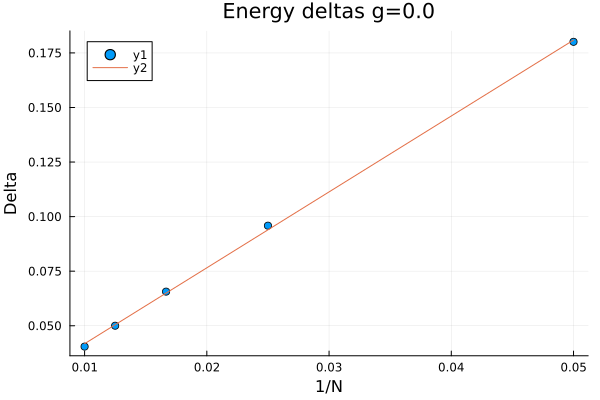

In [14]:
i=1
plot_delta_energies(j1j2spin_half_deltas_arr[i],N_arr,g_arr[i])

Which is pretty close to zero, indicating the system is gapless as expected

For g=g_c=0.241

The intercept for g=0 is 0.003511926213340998


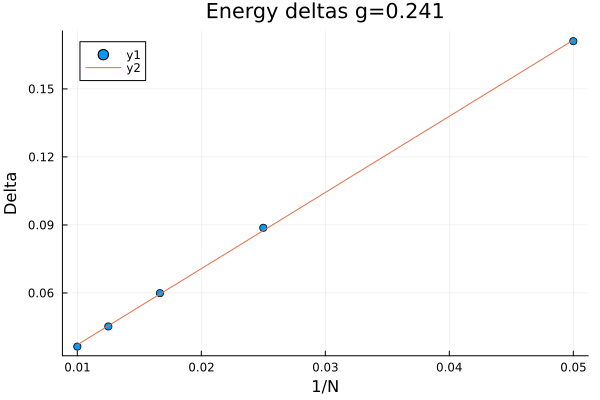

In [15]:
i=2
plot_delta_energies(j1j2spin_half_deltas_arr[i],N_arr,g_arr[i])

Which is pretty close to zero, indicating the system is gapless as expected for still being in the phase with g below gc

For g=0.48:

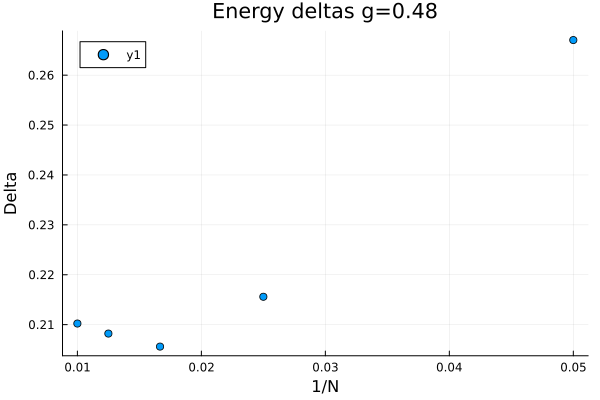

In [16]:
i=3
plot_delta_energies(j1j2spin_half_deltas_arr[i],N_arr,g_arr[i],plot_fit=false)

Here we can see an obvious finite gap as expected from being deep in the dimerized phase. The trend of the points indicates an intercept with the y axis which is non-zero.

## 3. Spin-spin correlations

In [17]:
function plot_SzSz_correlations(corr_mat, x_array, g , plot_fit_type="power_law")
    N = x_array[end]
    
    """
    #x = x_array[100:end] .- 100
    #y= log10.(abs.(corr_mat[100,100:end]))
    x = 1 ./ (x_array[101:end] .- 100)
    y = abs.(corr_mat[100,101:end])
    """
    x = x_array[101:end] .- 100
    y = abs.(corr_mat[100,101:end])
    plt=scatter(x,y,xlabel="x-100",ylabel="Sₓ₀⃗⋅Sₓ⃗",title="Spin correlations for g=$g",label="correlations")
    if plot_fit_type=="power_law"
        fun_power(x, a) = a[1] ./ (x .^ a[2])
        res = LsqFit.curve_fit(fun_power, x, y, [100.,1.]);
        plot!(x , fun_power(x, coef(res)),label="fit")
        α_g=coef(res)[2]
        println("The exponent α for g=$g was found from the fit to be $α_g")
    end
    if plot_fit_type=="exp_law"
        fun_exp(x, a) = a[1]*exp.(-x./a[2])
        res = LsqFit.curve_fit(fun_exp, x, y, [0.,1.]);
        plot!(x , fun_exp(x, coef(res)),label="fit")
        α_g=coef(res)[2]
        println("The correlation length for g=$g was found from the fit to be $α_g")
    end
    return plt
end;

In [18]:
N = 200
x_array= [x for x in 1:N];
swp_num = 10
maxM = 100
J1=1.0;
g_array=[0 ,0.241, 0.48];

In [19]:
corr_mats=[]
for g in g_array
    energy, psi = J1J2_DMRG(N,1., g, swp_num, maxM ,0)
    push!(corr_mats, correlation_matrix(psi,"Sz","Sz"))
end

After sweep 1 energy=-87.90732132925154  maxlinkdim=4 maxerr=0.00E+00 time=0.511
After sweep 2 energy=-88.40009736494895  maxlinkdim=16 maxerr=0.00E+00 time=1.085
After sweep 3 energy=-88.4367923683276  maxlinkdim=64 maxerr=9.54E-17 time=1.927
After sweep 4 energy=-88.44026222450567  maxlinkdim=100 maxerr=3.54E-11 time=4.367
After sweep 5 energy=-88.4412149980951  maxlinkdim=100 maxerr=3.27E-10 time=6.261
After sweep 6 energy=-88.44152457900702  maxlinkdim=100 maxerr=2.73E-09 time=6.039
After sweep 7 energy=-88.44155419065386  maxlinkdim=100 maxerr=3.52E-09 time=5.719
After sweep 8 energy=-88.44155471067545  maxlinkdim=100 maxerr=2.85E-09 time=5.792
After sweep 9 energy=-88.44155471372999  maxlinkdim=100 maxerr=2.80E-09 time=6.856
After sweep 10 energy=-88.44155471369858  maxlinkdim=100 maxerr=2.81E-09 time=6.110
After sweep 1 energy=-79.85921543022567  maxlinkdim=4 maxerr=0.00E+00 time=0.649
After sweep 2 energy=-80.26699841583698  maxlinkdim=16 maxerr=0.00E+00 time=1.808
After sweep 

For g=0:

The exponent α for g=0.0 was found from the fit to be 0.9747021126405984


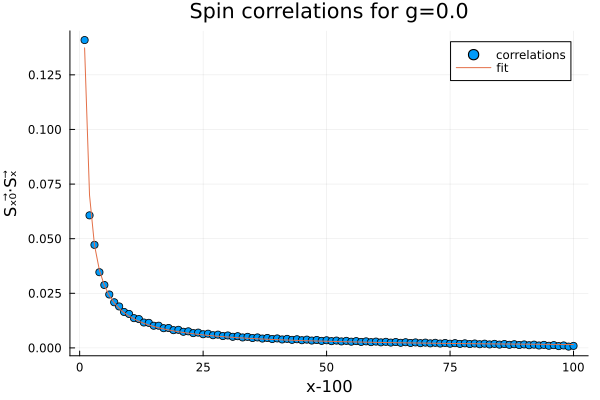

In [20]:
i=1
plt=plot_SzSz_correlations(corr_mats[i], x_array, g_array[i])

For g=g_c=0.241

The exponent α for g=0.241 was found from the fit to be 1.1334176605526294


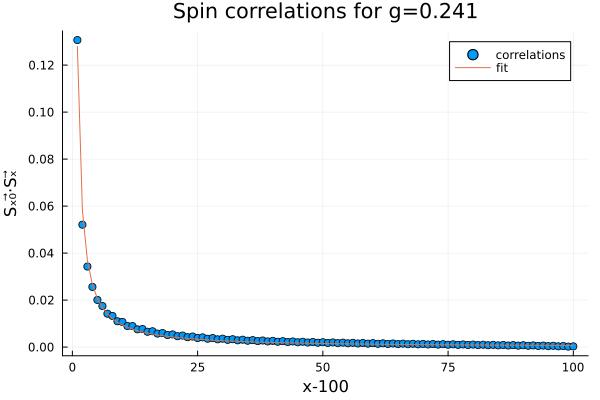

In [21]:
i=2
plot_SzSz_correlations(corr_mats[i], x_array, g_array[i])

For g=0.48:

The correlation length for g=0.48 was found from the fit to be 1.8987928552306337


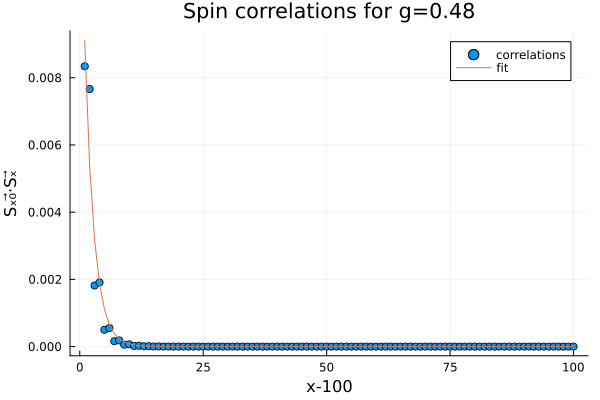

In [22]:
i=3
plot_SzSz_correlations(corr_mats[i], x_array, g_array[i],"exp_law")

# 2. spin-1 - Haldane gap

In [23]:
function bilinear_biquadtatic_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64, QN_subspace::Int64; zeros_init::Bool = false)
    
    # Generate an index set representing quantum sites with spin S=1
    sites = siteinds("S=1", N; conserve_qns=true)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N-1
        ampo += J1, "Sz", j, "Sz", j + 1
        ampo += J1/2, "S+", j, "S-", j + 1
        ampo += J1/2, "S-", j, "S+", j + 1
        
        #J2 
        ampo += J2, "Sz", j, "Sz", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S-", j, "S+", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S-", j, "S+", j + 1
        ampo += J2/2, "S-", j, "S+", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/2, "S+", j, "S-", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/2, "Sz", j, "Sz", j + 1, "S-", j, "S+", j + 1
        ampo += J2/2, "Sz", j, "Sz", j + 1, "S+", j, "S-", j + 1
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    # psi0 = randomMPS(sites,10)
    if zeros_init
        state= [isodd(n) ? "Up" : "Dn" for n=1:N]
        if QN_subspace == 1
            state[2]="0"
        end
        if QN_subspace == 2
            state[2]="Up"
        end
    else
        state= ["0" for n=1:N]
        if QN_subspace == 1
            state[1]="Up"
        end
        if QN_subspace == 2
            state[1]="Up"
            state[2]="Up"
        end
    end
    psi0 = MPS(sites,state)
    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps)

    return energy, psi
end;

## 1. System gap for J2 between 0 and 1/3

In [24]:
N_arr= [ n for n in 10:10:40];
swp_num = 10
maxM = 100;

In [25]:
J2_arr=[ j for j in 0:1/12:1/3];

In [26]:
deltas_arr=[]
for g in J2_arr
    push!(deltas_arr,energy_gap_calc(bilinear_biquadtatic_DMRG,N_arr,g,swp_num,maxM,0,2,zeros_init=true))
end;

After sweep 1 energy=-12.816728929088047  maxlinkdim=9 maxerr=0.00E+00 time=0.404
After sweep 2 energy=-12.882204117762932  maxlinkdim=81 maxerr=3.30E-17 time=0.156
After sweep 3 energy=-12.894347066271527  maxlinkdim=100 maxerr=2.36E-10 time=0.214
After sweep 4 energy=-12.894559406643848  maxlinkdim=100 maxerr=1.53E-11 time=0.221
After sweep 5 energy=-12.89456013145606  maxlinkdim=100 maxerr=2.35E-12 time=0.210
After sweep 6 energy=-12.894560132202859  maxlinkdim=99 maxerr=1.50E-12 time=0.213
After sweep 7 energy=-12.894560132204303  maxlinkdim=100 maxerr=5.66E-13 time=0.209
After sweep 8 energy=-12.894560132204308  maxlinkdim=100 maxerr=5.66E-13 time=0.211
After sweep 9 energy=-12.89456013220431  maxlinkdim=100 maxerr=5.66E-13 time=0.237
After sweep 10 energy=-12.894560132204294  maxlinkdim=100 maxerr=5.66E-13 time=0.247
After sweep 1 energy=-10.405142284919062  maxlinkdim=9 maxerr=0.00E+00 time=0.051
After sweep 2 energy=-11.98222270004214  maxlinkdim=81 maxerr=0.00E+00 time=0.101
A

After sweep 10 energy=-10.21337639915756  maxlinkdim=100 maxerr=1.91E-15 time=0.274
After sweep 1 energy=-22.998796096796468  maxlinkdim=9 maxerr=0.00E+00 time=0.107
After sweep 2 energy=-23.046826549391092  maxlinkdim=78 maxerr=9.31E-17 time=0.455
After sweep 3 energy=-23.047100886268854  maxlinkdim=100 maxerr=8.25E-11 time=1.504
After sweep 4 energy=-23.047442836572483  maxlinkdim=100 maxerr=1.45E-10 time=1.499
After sweep 5 energy=-23.048123180033038  maxlinkdim=100 maxerr=2.27E-10 time=1.616
After sweep 6 energy=-23.049263654809963  maxlinkdim=100 maxerr=3.23E-10 time=1.925
After sweep 7 energy=-23.05039129550728  maxlinkdim=100 maxerr=5.89E-10 time=2.184
After sweep 8 energy=-23.05093750671484  maxlinkdim=100 maxerr=5.20E-10 time=2.028
After sweep 9 energy=-23.05107585292633  maxlinkdim=100 maxerr=3.37E-10 time=1.623
After sweep 10 energy=-23.0511018183303  maxlinkdim=100 maxerr=3.09E-10 time=1.626
After sweep 1 energy=-20.567636370164994  maxlinkdim=9 maxerr=0.00E+00 time=0.125
A

After sweep 9 energy=-18.806387783868484  maxlinkdim=100 maxerr=9.40E-12 time=1.539
After sweep 10 energy=-18.806387838748357  maxlinkdim=100 maxerr=6.70E-12 time=1.451
After sweep 1 energy=-29.550935089170906  maxlinkdim=9 maxerr=0.00E+00 time=0.277
After sweep 2 energy=-29.596719539495535  maxlinkdim=78 maxerr=9.68E-17 time=0.961
After sweep 3 energy=-29.596741981454883  maxlinkdim=100 maxerr=6.85E-13 time=3.303
After sweep 4 energy=-29.596742085433107  maxlinkdim=100 maxerr=2.66E-13 time=4.418
After sweep 5 energy=-29.596742096430322  maxlinkdim=100 maxerr=3.63E-13 time=2.598
After sweep 6 energy=-29.596742117520638  maxlinkdim=100 maxerr=1.07E-12 time=2.364
After sweep 7 energy=-29.596742145986152  maxlinkdim=100 maxerr=1.23E-12 time=2.390
After sweep 8 energy=-29.596742178446263  maxlinkdim=100 maxerr=1.74E-12 time=2.566
After sweep 9 energy=-29.596742212382722  maxlinkdim=100 maxerr=1.86E-12 time=2.257
After sweep 10 energy=-29.596742246603636  maxlinkdim=100 maxerr=2.33E-12 time

After sweep 8 energy=-23.674104807578715  maxlinkdim=100 maxerr=3.25E-10 time=3.262
After sweep 9 energy=-23.678570452838244  maxlinkdim=100 maxerr=4.25E-10 time=2.701
After sweep 10 energy=-23.681802377234614  maxlinkdim=100 maxerr=4.22E-10 time=2.688
After sweep 1 energy=-32.68052359735364  maxlinkdim=9 maxerr=0.00E+00 time=0.274
After sweep 2 energy=-32.70556884322214  maxlinkdim=80 maxerr=9.56E-17 time=1.089
After sweep 3 energy=-32.70557372399415  maxlinkdim=100 maxerr=6.99E-14 time=4.877
After sweep 4 energy=-32.705573742976355  maxlinkdim=100 maxerr=1.65E-14 time=5.907
After sweep 5 energy=-32.70557374314932  maxlinkdim=100 maxerr=9.63E-15 time=4.407
After sweep 6 energy=-32.70557374315072  maxlinkdim=100 maxerr=2.84E-15 time=4.310
After sweep 7 energy=-32.70557374315062  maxlinkdim=100 maxerr=1.50E-15 time=3.861
After sweep 8 energy=-32.70557374315063  maxlinkdim=100 maxerr=1.50E-15 time=4.685
After sweep 9 energy=-32.705573743150715  maxlinkdim=100 maxerr=1.50E-15 time=3.729
A

After sweep 8 energy=-24.529709586798493  maxlinkdim=100 maxerr=1.52E-09 time=1.878
After sweep 9 energy=-24.5398682509957  maxlinkdim=100 maxerr=1.35E-09 time=1.985
After sweep 10 energy=-24.54725735181706  maxlinkdim=100 maxerr=1.43E-09 time=2.191


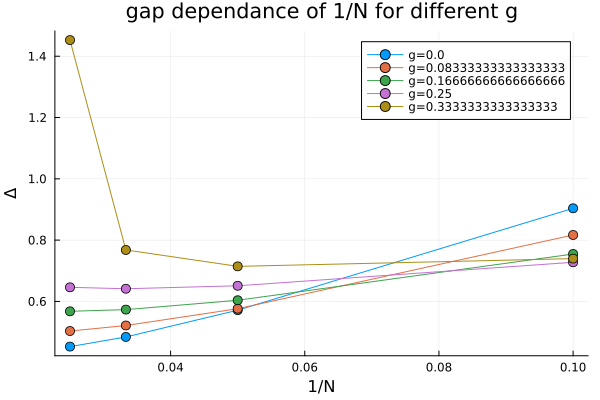

In [27]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

plot(x, y; marker = (:circle,5),title="gap dependance of 1/N for different g",label="g=$g",xlabel="1/N",ylabel= "Δ")
for i in 2:5
    g=J2_arr[i]
    y = deltas_arr[i]
    plot!(x, y ; marker = (:circle,5),label="g=$g")
end
plot!()

We get that for all J2 between 0 and 1/3 the energy gap is finite and non zero. I don't see any obvious trend to make a fit to find the energy gap though. I do suspect something is odd with the results of $g =1/3 $ and high N, maybe the ground state wasn't reached due to low number of sweeps or maximal bond dimension.

### 2.a Energy gaps between the ground states of S=0 and S=1 subspaces. For J2 between 0 and 1/3

In [28]:
#N_arr= [ n for n in 20:20:100];
N_arr= [ n for n in 10:10:40];
swp_num = 20
maxM = 100;

In [29]:
s0s1_res_arr=[]
for g in J2_arr
    push!(s0s1_res_arr,energy_gap_calc(bilinear_biquadtatic_DMRG,N_arr,g,swp_num,maxM,0,1;return_states=true))
end;

After sweep 1 energy=-12.822757157831685  maxlinkdim=9 maxerr=0.00E+00 time=0.121
After sweep 2 energy=-12.894552371326608  maxlinkdim=81 maxerr=0.00E+00 time=0.122
After sweep 3 energy=-12.894560132173  maxlinkdim=100 maxerr=4.47E-12 time=0.177
After sweep 4 energy=-12.894560132204289  maxlinkdim=100 maxerr=5.87E-13 time=0.213
After sweep 5 energy=-12.894560132204269  maxlinkdim=100 maxerr=5.66E-13 time=0.170
After sweep 6 energy=-12.894560132204283  maxlinkdim=100 maxerr=5.66E-13 time=0.168
After sweep 7 energy=-12.894560132204294  maxlinkdim=100 maxerr=5.66E-13 time=0.177
After sweep 8 energy=-12.894560132204298  maxlinkdim=100 maxerr=5.66E-13 time=0.180
After sweep 9 energy=-12.894560132204273  maxlinkdim=100 maxerr=5.66E-13 time=0.175
After sweep 10 energy=-12.894560132204269  maxlinkdim=100 maxerr=5.66E-13 time=0.190
After sweep 11 energy=-12.894560132204273  maxlinkdim=100 maxerr=5.66E-13 time=0.191
After sweep 12 energy=-12.894560132204287  maxlinkdim=100 maxerr=5.66E-13 time=0

After sweep 19 energy=-40.83992896842153  maxlinkdim=100 maxerr=1.45E-09 time=1.103
After sweep 20 energy=-40.83992896842148  maxlinkdim=100 maxerr=1.45E-09 time=1.198
After sweep 1 energy=-40.601284269263644  maxlinkdim=9 maxerr=0.00E+00 time=0.175
After sweep 2 energy=-40.83446642357081  maxlinkdim=81 maxerr=0.00E+00 time=0.536
After sweep 3 energy=-40.8349106196032  maxlinkdim=100 maxerr=2.54E-11 time=1.114
After sweep 4 energy=-40.834919348473925  maxlinkdim=100 maxerr=1.46E-10 time=1.176
After sweep 5 energy=-40.834919377053176  maxlinkdim=100 maxerr=9.86E-11 time=1.163
After sweep 6 energy=-40.83491937705915  maxlinkdim=100 maxerr=7.44E-11 time=1.148
After sweep 7 energy=-40.83491937705897  maxlinkdim=100 maxerr=7.44E-11 time=1.269
After sweep 8 energy=-40.83491937705885  maxlinkdim=100 maxerr=7.44E-11 time=1.293
After sweep 9 energy=-40.83491937705896  maxlinkdim=100 maxerr=7.44E-11 time=1.200
After sweep 10 energy=-40.83491937705887  maxlinkdim=100 maxerr=7.44E-11 time=1.187
Af

After sweep 17 energy=-10.951410510773005  maxlinkdim=100 maxerr=3.57E-15 time=0.273
After sweep 18 energy=-10.951410510773009  maxlinkdim=100 maxerr=3.57E-15 time=0.256
After sweep 19 energy=-10.951410510772995  maxlinkdim=100 maxerr=3.57E-15 time=0.263
After sweep 20 energy=-10.951410510772998  maxlinkdim=100 maxerr=3.57E-15 time=0.262
After sweep 1 energy=-22.762940657427727  maxlinkdim=9 maxerr=0.00E+00 time=0.143
After sweep 2 energy=-23.050567183481427  maxlinkdim=81 maxerr=0.00E+00 time=0.459
After sweep 3 energy=-23.051110133082044  maxlinkdim=100 maxerr=4.14E-10 time=1.092
After sweep 4 energy=-23.05111035443377  maxlinkdim=100 maxerr=5.00E-11 time=1.299
After sweep 5 energy=-23.05111035449949  maxlinkdim=100 maxerr=4.61E-11 time=1.308
After sweep 6 energy=-23.051110354499414  maxlinkdim=100 maxerr=4.61E-11 time=1.518
After sweep 7 energy=-23.051110354499396  maxlinkdim=100 maxerr=4.61E-11 time=1.317
After sweep 8 energy=-23.05111035449944  maxlinkdim=100 maxerr=4.61E-11 time=

After sweep 15 energy=-47.18184433243426  maxlinkdim=100 maxerr=1.84E-10 time=3.027
After sweep 16 energy=-47.18184433245378  maxlinkdim=100 maxerr=1.84E-10 time=3.311
After sweep 17 energy=-47.181844332463385  maxlinkdim=100 maxerr=1.84E-10 time=3.196
After sweep 18 energy=-47.18184433246921  maxlinkdim=100 maxerr=1.84E-10 time=3.260
After sweep 19 energy=-47.18184433247281  maxlinkdim=100 maxerr=1.84E-10 time=3.068
After sweep 20 energy=-47.18184433247543  maxlinkdim=100 maxerr=1.84E-10 time=3.294
After sweep 1 energy=-47.127895490657046  maxlinkdim=9 maxerr=0.00E+00 time=0.283
After sweep 2 energy=-47.18154752874661  maxlinkdim=81 maxerr=9.98E-17 time=1.134
After sweep 3 energy=-47.18173878262158  maxlinkdim=100 maxerr=3.25E-12 time=3.012
After sweep 4 energy=-47.181743019434236  maxlinkdim=100 maxerr=3.75E-12 time=3.338
After sweep 5 energy=-47.181743155375315  maxlinkdim=100 maxerr=7.05E-12 time=3.111
After sweep 6 energy=-47.18174315839018  maxlinkdim=100 maxerr=5.44E-12 time=3.9

After sweep 14 energy=-19.408994922853175  maxlinkdim=100 maxerr=1.08E-13 time=1.274
After sweep 15 energy=-19.40899492285317  maxlinkdim=100 maxerr=1.08E-13 time=1.200
After sweep 16 energy=-19.408994922853154  maxlinkdim=100 maxerr=1.08E-13 time=1.260
After sweep 17 energy=-19.408994922853168  maxlinkdim=100 maxerr=1.08E-13 time=1.294
After sweep 18 energy=-19.408994922853168  maxlinkdim=100 maxerr=1.08E-13 time=1.166
After sweep 19 energy=-19.408994922853214  maxlinkdim=100 maxerr=1.08E-13 time=1.255
After sweep 20 energy=-19.40899492285315  maxlinkdim=100 maxerr=1.08E-13 time=1.204
After sweep 1 energy=-29.07198420836348  maxlinkdim=9 maxerr=0.00E+00 time=0.252
After sweep 2 energy=-29.595903153356733  maxlinkdim=81 maxerr=0.00E+00 time=1.524
After sweep 3 energy=-29.59677626634695  maxlinkdim=100 maxerr=3.13E-10 time=2.121
After sweep 4 energy=-29.596777642846384  maxlinkdim=100 maxerr=2.54E-11 time=2.310
After sweep 5 energy=-29.59677764594084  maxlinkdim=100 maxerr=1.58E-11 time

After sweep 12 energy=-7.5633473719829905  maxlinkdim=99 maxerr=7.42E-15 time=0.238
After sweep 13 energy=-7.563347371982984  maxlinkdim=99 maxerr=7.42E-15 time=0.265
After sweep 14 energy=-7.563347371982994  maxlinkdim=99 maxerr=7.42E-15 time=0.290
After sweep 15 energy=-7.563347371982978  maxlinkdim=99 maxerr=7.42E-15 time=0.234
After sweep 16 energy=-7.56334737198299  maxlinkdim=99 maxerr=7.42E-15 time=0.270
After sweep 17 energy=-7.56334737198299  maxlinkdim=99 maxerr=7.42E-15 time=0.273
After sweep 18 energy=-7.563347371982985  maxlinkdim=99 maxerr=7.42E-15 time=0.272
After sweep 19 energy=-7.563347371982985  maxlinkdim=99 maxerr=7.42E-15 time=0.287
After sweep 20 energy=-7.563347371982997  maxlinkdim=99 maxerr=7.42E-15 time=0.264
After sweep 1 energy=-7.554726576145458  maxlinkdim=9 maxerr=0.00E+00 time=0.044
After sweep 2 energy=-7.5564215214189305  maxlinkdim=81 maxerr=1.82E-17 time=0.181
After sweep 3 energy=-7.556422512648479  maxlinkdim=100 maxerr=1.49E-14 time=0.298
After s

After sweep 10 energy=-24.323113847901762  maxlinkdim=100 maxerr=1.50E-15 time=2.172
After sweep 11 energy=-24.32311384790175  maxlinkdim=100 maxerr=1.50E-15 time=2.107
After sweep 12 energy=-24.323113847901766  maxlinkdim=100 maxerr=1.50E-15 time=2.164
After sweep 13 energy=-24.323113847901812  maxlinkdim=100 maxerr=1.50E-15 time=2.080
After sweep 14 energy=-24.323113847901794  maxlinkdim=100 maxerr=1.50E-15 time=2.076
After sweep 15 energy=-24.323113847901798  maxlinkdim=100 maxerr=1.50E-15 time=2.171
After sweep 16 energy=-24.323113847901816  maxlinkdim=100 maxerr=1.50E-15 time=2.134
After sweep 17 energy=-24.323113847901805  maxlinkdim=100 maxerr=1.50E-15 time=2.924
After sweep 18 energy=-24.323113847901798  maxlinkdim=100 maxerr=1.50E-15 time=1.983
After sweep 19 energy=-24.323113847901805  maxlinkdim=100 maxerr=1.50E-15 time=2.044
After sweep 20 energy=-24.32311384790177  maxlinkdim=100 maxerr=1.50E-15 time=2.057
After sweep 1 energy=-32.0338228768072  maxlinkdim=9 maxerr=0.00E+0

After sweep 10 energy=-12.666666666666668  maxlinkdim=4 maxerr=1.10E-28 time=0.124
After sweep 11 energy=-12.666666666666671  maxlinkdim=4 maxerr=1.08E-28 time=0.122
After sweep 12 energy=-12.666666666666668  maxlinkdim=4 maxerr=7.67E-29 time=0.099
After sweep 13 energy=-12.666666666666671  maxlinkdim=4 maxerr=6.10E-30 time=0.087
After sweep 14 energy=-12.66666666666668  maxlinkdim=4 maxerr=4.61E-29 time=0.115
After sweep 15 energy=-12.666666666666673  maxlinkdim=4 maxerr=3.96E-29 time=0.092
After sweep 16 energy=-12.666666666666666  maxlinkdim=4 maxerr=8.85E-29 time=0.129
After sweep 17 energy=-12.66666666666667  maxlinkdim=4 maxerr=9.41E-30 time=0.118
After sweep 18 energy=-12.666666666666657  maxlinkdim=4 maxerr=1.73E-28 time=0.131
After sweep 19 energy=-12.666666666666659  maxlinkdim=4 maxerr=5.12E-29 time=0.098
After sweep 20 energy=-12.666666666666675  maxlinkdim=4 maxerr=1.10E-27 time=0.146
After sweep 1 energy=-12.66284800261211  maxlinkdim=9 maxerr=0.00E+00 time=0.126
After sw

After sweep 10 energy=-26.00000000000001  maxlinkdim=2 maxerr=1.03E-29 time=0.100
After sweep 11 energy=-25.999999999999968  maxlinkdim=2 maxerr=1.18E-30 time=0.151
After sweep 12 energy=-26.00000000000001  maxlinkdim=2 maxerr=9.40E-31 time=0.085
After sweep 13 energy=-26.000000000000032  maxlinkdim=2 maxerr=2.10E-30 time=0.106
After sweep 14 energy=-26.00000000000003  maxlinkdim=2 maxerr=9.25E-31 time=0.141
After sweep 15 energy=-26.0  maxlinkdim=2 maxerr=2.44E-30 time=0.105
After sweep 16 energy=-25.999999999999993  maxlinkdim=2 maxerr=1.11E-30 time=0.134
After sweep 17 energy=-26.00000000000002  maxlinkdim=2 maxerr=9.93E-31 time=0.090
After sweep 18 energy=-25.999999999999975  maxlinkdim=2 maxerr=1.20E-30 time=0.106
After sweep 19 energy=-25.99999999999998  maxlinkdim=2 maxerr=1.47E-30 time=0.141
After sweep 20 energy=-25.999999999999996  maxlinkdim=2 maxerr=9.74E-31 time=0.099


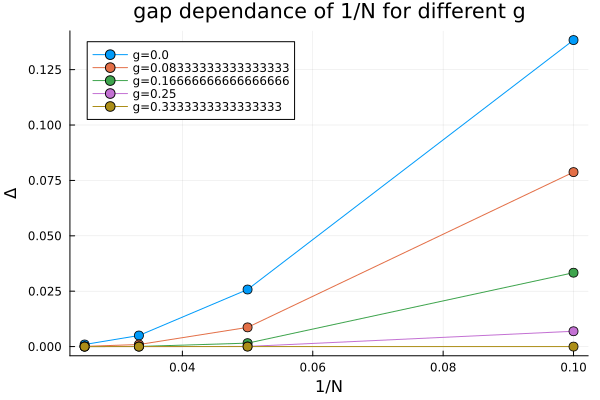

In [40]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = s0s1_res_arr[i][1]

plot(x, y; marker = (:circle,5),title="gap dependance of 1/N for different g",label="g=$g",xlabel="1/N",ylabel= "Δ")
for i in 2:5
    g=J2_arr[i]
    y = s0s1_res_arr[i][1]
    plot!(x, y ; marker = (:circle,5),label="g=$g")
end
plot!()

For some unknown reason, plotting with logscale breaks the Plots module. Here is the plot for log($|\Delta|$) :

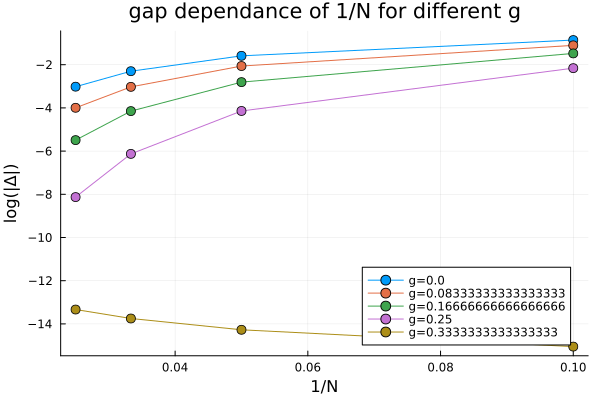

In [42]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = log10.(abs.(s0s1_res_arr[i][1]))

plot(x, y; marker = (:circle,5),title="gap dependance of 1/N for different g",label="g=$g",xlabel="1/N",ylabel= "log(|Δ|)")
for i in 2:5
    g=J2_arr[i]
    y = log10.(abs.(s0s1_res_arr[i][1]))
    plot!(x, y ; marker = (:circle,5),label="g=$g")
end
plot!(legend=:bottomright)

We can see here that the drop is not exponential altough we expected it to be.

### 2.b Local expectation value of Sz along the chain

In [33]:
function plot_and_talk_about_Sz_expectation(expectation_Sz,g,sum_near_edges::Int64)
    p=plot(expectation_Sz,xlabel="i",ylabel="⟨Sz⟩",title="g=$g ⟨Sz⟩'s across the chain")
    left=expectation_Sz[1]
    right=expectation_Sz[end]
    sum_left=sum([expectation_Sz[i] for i in 1:sum_near_edges])
    sum_right=sum([expectation_Sz[end-i+1] for i in 1:sum_near_edges])
    println("For g=$g")
    println("The spin values at the edges are- Left=$left Right=$right")
    println("The spin sum of $sum_near_edges nearest to the edges are- Left=$sum_left Right=$sum_right")
    return p
end;

In [43]:
sum_near_edges=Int64(20);

For g=0.0
The spin values at the edges are- Left=0.5318126208228717 Right=0.5318126193180567
The spin sum of 20 nearest to the edges are- Left=0.4999999985764418 Right=0.5000000014235563


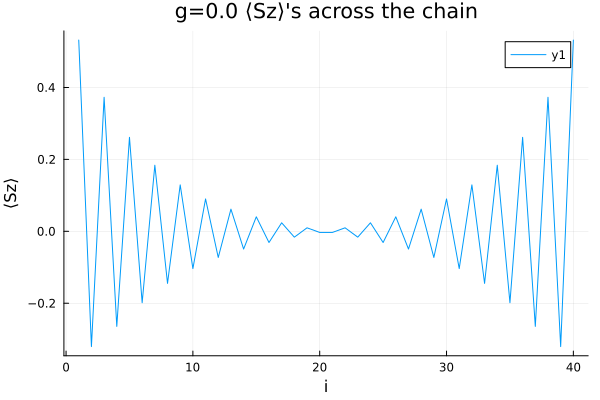

In [35]:
i=1
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

For g=0.08333333333333333
The spin values at the edges are- Left=0.5824814380978243 Right=0.5824814380611688
The spin sum of 20 nearest to the edges are- Left=0.4999999999676473 Right=0.5000000000323533


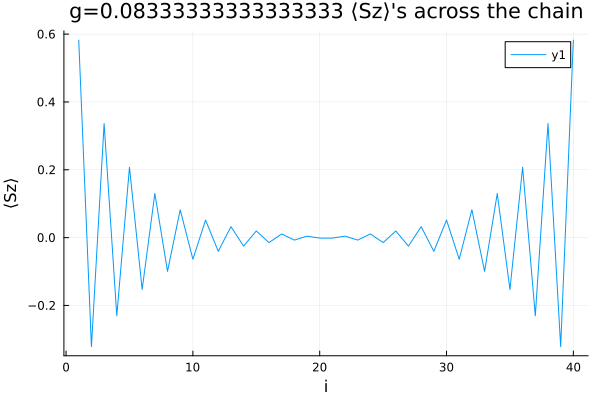

In [36]:
i=2
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

For g=0.16666666666666666
The spin values at the edges are- Left=0.6251588249322139 Right=0.6251588249272337
The spin sum of 20 nearest to the edges are- Left=0.5000000000066611 Right=0.49999999999333955


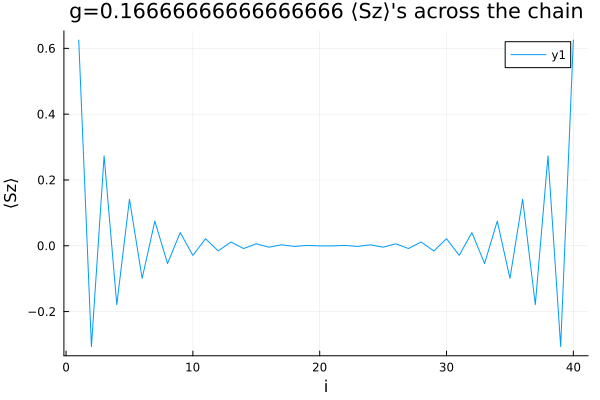

In [37]:
i=3
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

For g=0.25
The spin values at the edges are- Left=0.6552035543643653 Right=0.6552035543642358
The spin sum of 20 nearest to the edges are- Left=0.5000000000000244 Right=0.4999999999999781


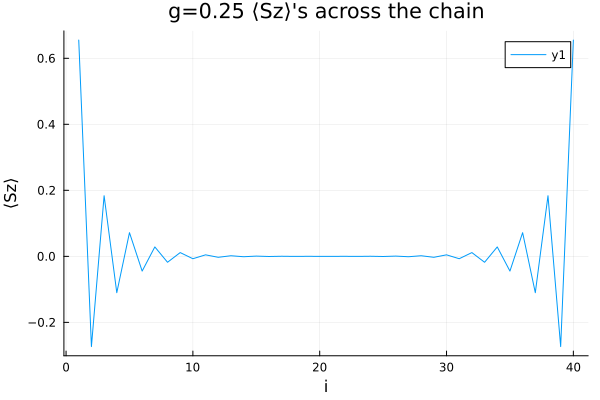

In [38]:
i=4
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

For gs up to 1/4, the sums of the spins up to the middle of the chain is 1/2 in each of the sides.
The spins exactly at the edges are between 1/2 and 2/3 for the different values of g.

For g=0.3333333333333333
The spin values at the edges are- Left=0.6666666666666683 Right=0.666666666666666
The spin sum of 20 nearest to the edges are- Left=0.4999999999999987 Right=0.5000000000000021


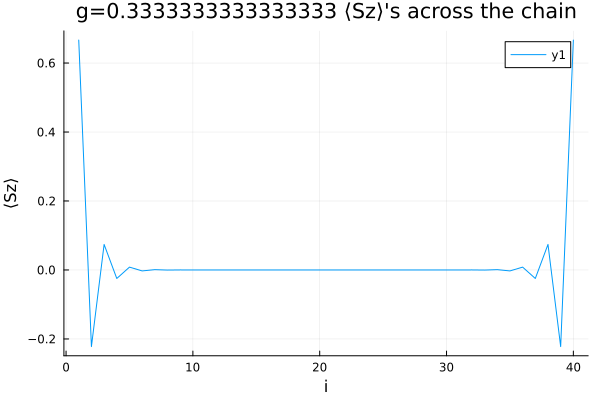

In [39]:
i=5
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

for g=1/3, the spin of the edges is 2/3 and the sum from the middle of the chain to each side sums to 1/2, just as was observed for the states in HW3 Q3 -aklt model section 2